Import needed libraries

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import matplotlib.pyplot as plt

Class for all we need

In [51]:
class CNN:

    def __init__(self) -> None:
        pass

    # load the dataset (MNIST)
    def load_dataset(self):
        with open('dataset/mnist_train.csv', 'r') as csv_file: # load training set
            reader = csv.reader(csv_file)
            self.y_train = []
            self.x_train = []

            for p in reader:
                label = p[0]
                self.y_train.append(label)   # add label
                image = p[1:]
                image = np.array(image, dtype='float32')   # convert image pixles to np array
                image = image.reshape((28,28))   # reshape image 
                self.x_train.append(image)

        self.y_train = np.array(self.y_train, dtype='int')
        self.x_train = np.array(self.x_train)

        # do the same for test data
        with open('dataset/mnist_test.csv', 'r') as csv_file:
            reader = csv.reader(csv_file)
            self.y_test = []
            self.x_test = []

            for p in reader:
                label = p[0]
                self.y_test.append(label)
                image = p[1:]
                image = np.array(image, dtype='float32')
                image = image.reshape((28,28))
                self.x_test.append(image)

        self.y_test = np.array(self.y_test, dtype='int')
        self.x_test = np.array(self.x_test)


    # show one instance of each class
    def show_instances(self):
        class_examples = {}  # save existing classes

        for image, label in zip(self.x_train, self.y_train):   # select unique classes
            if label not in class_examples:
                class_examples[label] = image

            if len(class_examples) == 10:
                break

        # Plot one instance of each class
        plt.figure(figsize=(10, 4))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(class_examples[i], cmap='gray')
            plt.title(f'Class {i}')
            plt.axis('off')

        plt.show()

        # one-hot encoding for labels
        self.y_train = to_categorical(self.y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)

        # create validation data from the training set
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)


    # create model with given parameters
    def create_model(self, num_filters_2=64, dropout_rate=0.5, kernel_size=(3, 3)):
        model = Sequential()

        # first convolutional layer
        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        # batch normalization
        model.add(BatchNormalization())
        # max pooling
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        # second convolutional layer with parameters using cross validation
        model.add(Conv2D(filters=num_filters_2, kernel_size=kernel_size, activation='relu'))
        # batch normalization
        model.add(BatchNormalization())
        # max pooling
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        # flattening
        model.add(Flatten())

        # FC classifier
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(10, activation='softmax'))

        # model compile ans summary
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model = model
        self.model.summary()

    # parameter tuning to find the best number of filters, kernel size and dropout
    def find_best_params(self):
        # hyperparameters
        params = {
            'num_filters_2': [32, 64, 128],
            'dropout_rate': [0.3, 0.5, 0.7],
            'kernel_size': [(3, 3), (5, 5)]
        }

        self.best_score = 0
        self.best_params = None
        # loop through candidate parameters and select the best parameters that get the max result on test set
        for num_filters_2 in params['num_filters_2']:
            for dropout_rate in params['dropout_rate']:
                for kernel_size in params['kernel_size']:
                    self.create_model(num_filters_2=num_filters_2, dropout_rate=dropout_rate, kernel_size=kernel_size)
                    history = self.model.fit(self.x_train, self.y_train, validation_data=(self.x_test, self.y_test), epochs=10, batch_size=200, verbose=0)
                    val_accuracy = max(history.history['val_accuracy'])
                    # update the best result and best parameters
                    if val_accuracy > self.best_score:
                        self.best_score = val_accuracy
                        self.best_params = {'num_filters_2': num_filters_2, 'dropout_rate': dropout_rate, 'kernel_size': kernel_size}
        

    # train the best model on the training set and report train, validation and test results
    def train_eval(self):
        # train the final model with the best parameters
        self.create_model(num_filters_2=self.best_params['num_filters_2'], dropout_rate=self.best_params['dropout_rate'], kernel_size=self.best_params['kernel_size'])
        history = self.model.fit(self.x_train, self.y_train, validation_split=0.2, epochs=10, batch_size=200, verbose=1)

        # evaluate the model on the training, validation, and test data
        train_loss, train_accuracy = self.model.evaluate(self.x_train, self.y_train, verbose=0)
        val_loss, val_accuracy     = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        test_loss, test_accuracy   = self.model.evaluate(self.x_test, self.y_test, verbose=0)

        # report accuracy 
        print(f'Train accuracy: {train_accuracy}')
        print(f'Validation accuracy: {val_accuracy}')
        print(f'Test accuracy: {test_accuracy}')

        # plotting the history
        plt.figure(figsize=(12, 4))
        # train and validation's loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # train and validation's accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()




### main program

define model and load data and show one instance of each class

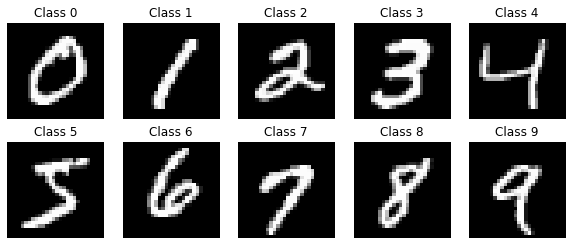

In [52]:
net = CNN()
net.load_dataset()
net.show_instances()

check model creation
using dropout: Dropout has crucial role in improving model generalization and reducing overfitting. Its benefits have been demonstrated across a wide range of applications and architectures, making it a valuable tool in the toolbox of machine learning practitioners. While it may not be necessary or beneficial in every scenarios but since MNIST is not a complex dataset, I think it is good to have it.

In [47]:
net.create_model()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_48 (Ba  (None, 26, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_49 (Ba  (None, 11, 11, 64)        256       
 tchNormalization)                                               
                                                     

parameter tuning

In [37]:
net.find_best_params()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_12 (Ba  (None, 26, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 11, 11, 32)        128       
 tchNormalization)                                               
                                                      

show best parameters

In [38]:
net.best_params

{'num_filters_2': 128, 'dropout_rate': 0.3, 'kernel_size': (5, 5)}

train the best model and show results on train, validation and test dataset

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_52 (Ba  (None, 26, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 9, 9, 128)         102528    
                                                                 
 batch_normalization_53 (Ba  (None, 9, 9, 128)         512       
 tchNormalization)                                               
                                                     

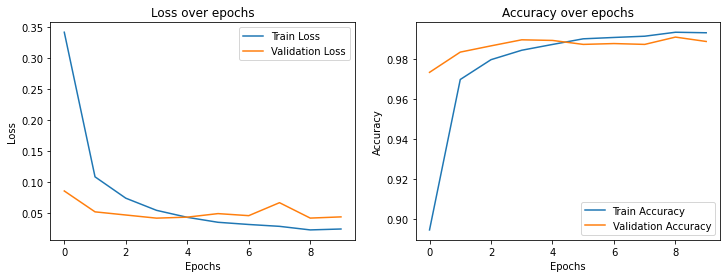

In [53]:
net.train_eval()